In [2]:
pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 2.7 MB/s eta 0:00:00


In [3]:
pip install langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [4]:
pip install langchain[text-splitters]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 3.9 MB/s eta 0:00:00


In [5]:
!pip install pypandoc

In [6]:
pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.4 MB/s eta 0:00:00


In [7]:
pip install PDFMiner.six

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.7 MB/s eta 0:00:00


**Reading the Amex Creditcard statement PDF Document**

In [9]:
from langchain_community.document_loaders import PyPDFLoader
import os

pdf_path = "/content/04-28-2024.pdf"
pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
print(pdf_name)


loader = PyPDFLoader(pdf_path)
pages = loader.load_and_split()

04-28-2024


In [11]:
pages[5]

Document(page_content="04/03/24 LAFITNESS CORP INTL IRVINE CA\nMEMBERSHIP FEES$10.00\n04/03/24 AplPay COMCAST CHICAGO CS1X (800)266-2278 IL\nCABLE SVCS$25.00\n04/07/24 SPOTIFY USA NEW YORK NY\nDIRECT MKTG MISC$6.53\n04/07/24 AplPay JEWEL OSCO 3443 3443 CHICAGO IL\n800-898-4027$20.11\n04/08/24 BROADWAY ARMORY 0000 CHICAGO IL\n312-274-2146$2.00\n04/08/24 AplPay DUNKIN #343280 Q35 3432 CHICAGO IL\n773-988-6639$8.14\n04/08/24 AplPay TARGET 032722 09100032722 CHICAGO IL\n612-3044357$9.47\n04/09/24 AplPay TARGET 020792 09100020792 CHICAGO IL\n612-3044357$13.95\n04/09/24 AplPay TARGET 020792 09100020792 CHICAGO IL\n612-3044357$19.49\n04/10/24 Amazon Prime Amazon.com WA\nSUBSCRIPTION$7.49\n04/12/24 SAM'S CLUB 6444 6444 EVANSTON IL\nWHOLESALE CLUB$228.63\n04/12/24 SAM'S CLUB 6444 6444 EVANSTON IL\nWHOLESALE CLUB$11.62\n04/12/24 PARKINGMETER1 8772427901 0007 CHICAGO IL\n877-242-7901$2.75\n04/13/24 AplPay PAYRANGE MOBILE 0000 PORTLAND OR\n855-856-6398$25.00\n04/13/24 AplPay FARM SUPERMARKET 94160

**By Understanding the PDF, Determining the Start and end page of Transaction**

In [12]:
contentStartPage = 1
maxlength = int(len(pages)-1)
start_marker = "Card Ending xx-xxxxx"
end_marker = "Continued onnext"
startofpages= 0
endofpages = 0

# To find the beginning of the transactions
for i in range(2,maxlength):
  temp = pages[i].page_content
  start_pos = temp.find(start_marker)
  #end_pos = temp.find(end_marker)
  if (start_pos > 0):
    startofpages = i
    contentStartPage += 1
    break;

# To find the end of the transactions
for i in range(maxlength,2,-1):
  temp = pages[i].page_content
  end_pos = temp.find(end_marker)
  if (end_pos > 0):
    endofpages = i
    contentStartPage += 1
    break;


In [13]:
startofpages

4

In [14]:
endofpages

5

## **Extraction of Data**

In [15]:
import re
import pandas as pd

def extract_transaction_data(text):
    # Define regex patterns for extracting data
    date_pattern = r"\d{2}/\d{2}/\d{2}"
    amount_pattern = r"\$\d+\.\d{2}"
    name_pattern = r"(?<=\d{2}/\d{2}/\d{2} ).*(?=\n)"

    # Find all occurrences of date, name, and amount
    dates = re.findall(date_pattern, text)
    names = re.findall(name_pattern, text)
    amounts = re.findall(amount_pattern, text)

    # Create a DataFrame from the extracted data
    data = list(zip(dates, names, amounts))
    df = pd.DataFrame(data, columns=["date", "name", "amount"])
    return df

## **Handling the start of Transaction**

In [16]:
import re
import pandas as pd

text = pages[startofpages].page_content

pattern = r"(?<=Card Ending 8-11003)(.*?)(?=Continued)"

# Extract the relevant portion of the text
extracted_text = re.search(pattern, text, re.DOTALL)

if extracted_text:
    # Define regex patterns for extracting data
    date_pattern = r"\d{2}/\d{2}/\d{2}"
    amount_pattern = r"\$\d+\.\d{2}"
    name_pattern = r"(?<=\d{2}/\d{2}/\d{2} ).*(?=\n)"

    # Find all occurrences of date, name, and amount
    dates = re.findall(date_pattern, extracted_text.group())
    names = re.findall(name_pattern, extracted_text.group())
    amounts = re.findall(amount_pattern, extracted_text.group())

    # Create a DataFrame from the extracted data
    data = list(zip(dates, names, amounts))
    firstdf = pd.DataFrame(data, columns=["date", "name", "amount"])
    print(firstdf)
else:
    print("Pattern not found in the text")

       date                                               name  amount
0  03/25/24  DISPUTE CRREVERSAL -AplPay HERTZ CAR RENTAL $7...  $72.88
1  04/01/24             COMMONWEALTH EDISON COMPANY CHICAGO IL  $25.89
2  04/01/24                      LOT AEPS 000000045 CHICAGO IL   $3.00
3  04/02/24                           AplPay SUBWAY CHICAGO IL  $20.17
4  04/02/24                          STARBUCKS 800-782-7282 WA   $6.59
5  04/02/24         AplPay PATEL BROTHERS 000000001 CHICAGO IL  $61.90


## **Handling the End of Transaction**

In [17]:
beginpg = startofpages+1  # To eliminate the first page as it has other parameters
endingpg = endofpages+1  # To stop at the exact point
merged_df = pd.DataFrame(columns=["date", "name", "amount"])  # Initialize an empty DataFrame to store merged data

if beginpg == endingpg:
  endingpg = endingpg+1

for i in range(beginpg, endingpg):
    text = pages[i].page_content

    # Find the index of "Continued" and exclude everything after it
    index_continued = text.find("Continued")
    if index_continued != -1:
        text = text[:index_continued]

    # Extract data using the function
    df = extract_transaction_data(text)

    # Merge the extracted data with the existing data
    merged_df = pd.concat([merged_df, df], ignore_index=True)

# Print the merged DataFrame
print(merged_df)

        date                                               name   amount
0   04/03/24                      LAFITNESS CORP INTL IRVINE CA   $10.00
1   04/03/24       AplPay COMCAST CHICAGO CS1X (800)266-2278 IL   $25.00
2   04/07/24                            SPOTIFY USA NEW YORK NY    $6.53
3   04/07/24             AplPay JEWEL OSCO 3443 3443 CHICAGO IL   $20.11
4   04/08/24                    BROADWAY ARMORY 0000 CHICAGO IL    $2.00
5   04/08/24          AplPay DUNKIN #343280 Q35 3432 CHICAGO IL    $8.14
6   04/08/24        AplPay TARGET 032722 09100032722 CHICAGO IL    $9.47
7   04/09/24        AplPay TARGET 020792 09100020792 CHICAGO IL   $13.95
8   04/09/24        AplPay TARGET 020792 09100020792 CHICAGO IL   $19.49
9   04/10/24                         Amazon Prime Amazon.com WA    $7.49
10  04/12/24                   SAM'S CLUB 6444 6444 EVANSTON IL  $228.63
11  04/12/24                   SAM'S CLUB 6444 6444 EVANSTON IL   $11.62
12  04/12/24           PARKINGMETER1 8772427901 000

# **Merging  After Processing from unstructed data**

In [18]:
finance_df = pd.concat([firstdf, merged_df], ignore_index=True)
print(finance_df[0:])

        date                                               name   amount
0   03/25/24  DISPUTE CRREVERSAL -AplPay HERTZ CAR RENTAL $7...   $72.88
1   04/01/24             COMMONWEALTH EDISON COMPANY CHICAGO IL   $25.89
2   04/01/24                      LOT AEPS 000000045 CHICAGO IL    $3.00
3   04/02/24                           AplPay SUBWAY CHICAGO IL   $20.17
4   04/02/24                          STARBUCKS 800-782-7282 WA    $6.59
5   04/02/24         AplPay PATEL BROTHERS 000000001 CHICAGO IL   $61.90
6   04/03/24                      LAFITNESS CORP INTL IRVINE CA   $10.00
7   04/03/24       AplPay COMCAST CHICAGO CS1X (800)266-2278 IL   $25.00
8   04/07/24                            SPOTIFY USA NEW YORK NY    $6.53
9   04/07/24             AplPay JEWEL OSCO 3443 3443 CHICAGO IL   $20.11
10  04/08/24                    BROADWAY ARMORY 0000 CHICAGO IL    $2.00
11  04/08/24          AplPay DUNKIN #343280 Q35 3432 CHICAGO IL    $8.14
12  04/08/24        AplPay TARGET 032722 0910003272

Creating variable 'TransactionMethod' to determine what type of payment has been used. For instances, through Internet, Apple pay (Tap), Card (Swiping or tapping card) - This helps to know more which Transaction has high impact.

In [19]:
def get_transaction_method(name):
    if '.com' in name.lower():
        return 'Internet'
    elif 'aplpay' in name.lower():
        return 'Apple Pay'
    else:
        return 'Card'

# Create a new DataFrame with only the TransactionMethod column
transaction_method_df = finance_df['name'].apply(get_transaction_method).to_frame(name='TransactionMethod')

#transaction_method_df['transaction_id'] = range(1, len(transaction_method_df) + 1)  # Range starts from 1, excludes the upper limit

print(transaction_method_df)

   TransactionMethod
0          Apple Pay
1               Card
2               Card
3          Apple Pay
4               Card
5          Apple Pay
6               Card
7          Apple Pay
8               Card
9          Apple Pay
10              Card
11         Apple Pay
12         Apple Pay
13         Apple Pay
14         Apple Pay
15          Internet
16              Card
17              Card
18              Card
19         Apple Pay
20         Apple Pay
21              Card
22              Card
23              Card
24         Apple Pay
25              Card
26          Internet
27         Apple Pay
28         Apple Pay
29         Apple Pay
30          Internet


In [20]:
extracted_col = transaction_method_df['TransactionMethod']
finance_df=pd.concat([finance_df, extracted_col.rename("MethodOfTransaction")], axis=1)

In [21]:
finance_df

,date,name,amount,MethodOfTransaction
0,03/25/24,DISPUTE CRREVERSAL -AplPay HERTZ CAR RENTAL $7...,$72.88,Apple Pay
1,04/01/24,COMMONWEALTH EDISON COMPANY CHICAGO IL,$25.89,Card
2,04/01/24,LOT AEPS 000000045 CHICAGO IL,$3.00,Card
3,04/02/24,AplPay SUBWAY CHICAGO IL,$20.17,Apple Pay
4,04/02/24,STARBUCKS 800-782-7282 WA,$6.59,Card
5,04/02/24,AplPay PATEL BROTHERS 000000001 CHICAGO IL,$61.90,Apple Pay
6,04/03/24,LAFITNESS CORP INTL IRVINE CA,$10.00,Card
7,04/03/24,AplPay COMCAST CHICAGO CS1X (800)266-2278 IL,$25.00,Apple Pay
8,04/07/24,SPOTIFY USA NEW YORK NY,$6.53,Card
9,04/07/24,AplPay JEWEL OSCO 3443 3443 CHICAGO IL,$20.11,Apple Pay


**Cleaning**

Cleaning Variable 'name' - To clean locations, numbers and other https in it,

In [22]:
# Read the US cities and states CSV file
LocationData = pd.read_csv('/content/uscities.csv')

# Display the first few rows of the DataFrame
print(LocationData.head())

          city   city_ascii state_id  state_name  county_fips  county_name  \
0     New York     New York       NY    New York        36081       Queens   
1  Los Angeles  Los Angeles       CA  California         6037  Los Angeles   
2      Chicago      Chicago       IL    Illinois        17031         Cook   
3        Miami        Miami       FL     Florida        12086   Miami-Dade   
4      Houston      Houston       TX       Texas        48201       Harris   

       lat       lng  population  density source  military  incorporated  \
0  40.6943  -73.9249    18908608  11080.3  shape     False          True   
1  34.1141 -118.4068    11922389   3184.7  shape     False          True   
2  41.8375  -87.6866     8497759   4614.5  shape     False          True   
3  25.7840  -80.2101     6080145   4758.9  shape     False          True   
4  29.7860  -95.3885     5970127   1384.0  shape     False          True   

              timezone  ranking  \
0     America/New_York        1   
1  A

In [23]:
# Extract cities and states from DataFrame and convert to lists
cities = LocationData['city'].tolist()
states = LocationData['state_id'].tolist()

# Combine cities and states into one list for removal
remove_words = cities + states

# Function to clean the 'name' column
def clean_name(name):
    # Create a regular expression pattern to match the words to remove
    pattern = r'\b(?:{})\b'.format('|'.join(map(re.escape, remove_words)))
    # Remove the words from the name
    cleaned_name = re.sub(pattern, '', name, flags=re.IGNORECASE)
    # Remove extra spaces and punctuation
    cleaned_name = re.sub(r'\s+', ' ', cleaned_name).strip()
    return cleaned_name

# Apply the function to the 'name' column
finance_df['name'] = finance_df['name'].apply(clean_name)

# Display the cleaned DataFrame
print(finance_df)


        date                                               name   amount  \
0   03/25/24  DISPUTE CRREVERSAL -AplPay HERTZ CAR RENTAL $7...   $72.88   
1   04/01/24                               COMMONWEALTH COMPANY   $25.89   
2   04/01/24                                 LOT AEPS 000000045    $3.00   
3   04/02/24                                      AplPay SUBWAY   $20.17   
4   04/02/24                             STARBUCKS 800-782-7282    $6.59   
5   04/02/24                    AplPay PATEL BROTHERS 000000001   $61.90   
6   04/03/24                                LAFITNESS CORP INTL   $10.00   
7   04/03/24                  AplPay COMCAST CS1X (800)266-2278   $25.00   
8   04/07/24                                        SPOTIFY USA    $6.53   
9   04/07/24                             AplPay JEWEL 3443 3443   $20.11   
10  04/08/24                                        ARMORY 0000    $2.00   
11  04/08/24                     AplPay DUNKIN #343280 Q35 3432    $8.14   
12  04/08/24

In [24]:
remove_word = " USA"

# Function to clean the 'name' column
def clean_name(name):
    # Create a regular expression pattern to match the words to remove
    pattern = r'\b(?:{})\b'.format('|'.join(map(re.escape, remove_words)))
    # Remove the words from the name
    cleaned_name = re.sub(pattern, '', name, flags=re.IGNORECASE)
    # Remove extra spaces and punctuation
    cleaned_name = re.sub(r'\s+', ' ', cleaned_name).strip()
    return cleaned_name

# Apply the function to the 'name' column
finance_df['name'] = finance_df['name'].apply(clean_name)

# Display the cleaned DataFrame
print(finance_df)

        date                                               name   amount  \
0   03/25/24  DISPUTE CRREVERSAL -AplPay HERTZ CAR RENTAL $7...   $72.88   
1   04/01/24                               COMMONWEALTH COMPANY   $25.89   
2   04/01/24                                 LOT AEPS 000000045    $3.00   
3   04/02/24                                      AplPay SUBWAY   $20.17   
4   04/02/24                             STARBUCKS 800-782-7282    $6.59   
5   04/02/24                    AplPay PATEL BROTHERS 000000001   $61.90   
6   04/03/24                                LAFITNESS CORP INTL   $10.00   
7   04/03/24                  AplPay COMCAST CS1X (800)266-2278   $25.00   
8   04/07/24                                        SPOTIFY USA    $6.53   
9   04/07/24                             AplPay JEWEL 3443 3443   $20.11   
10  04/08/24                                        ARMORY 0000    $2.00   
11  04/08/24                     AplPay DUNKIN #343280 Q35 3432    $8.14   
12  04/08/24

In [25]:
finance_df

,date,name,amount,MethodOfTransaction
0,03/25/24,DISPUTE CRREVERSAL -AplPay HERTZ CAR RENTAL $7...,$72.88,Apple Pay
1,04/01/24,COMMONWEALTH COMPANY,$25.89,Card
2,04/01/24,LOT AEPS 000000045,$3.00,Card
3,04/02/24,AplPay SUBWAY,$20.17,Apple Pay
4,04/02/24,STARBUCKS 800-782-7282,$6.59,Card
5,04/02/24,AplPay PATEL BROTHERS 000000001,$61.90,Apple Pay
6,04/03/24,LAFITNESS CORP INTL,$10.00,Card
7,04/03/24,AplPay COMCAST CS1X (800)266-2278,$25.00,Apple Pay
8,04/07/24,SPOTIFY USA,$6.53,Card
9,04/07/24,AplPay JEWEL 3443 3443,$20.11,Apple Pay


# **Removing 'AplPay' from the name of service or purchase**

In [26]:
def remove_aplpay(name):
    # Create a regular expression pattern to match 'AplPay' followed by a space
    pattern = r'\bAplPay\s'
    # Remove 'AplPay' from the name
    cleaned_name = re.sub(pattern, '', name, flags=re.IGNORECASE)
    return cleaned_name

# Apply the function to the 'name' column
finance_df['name'] = finance_df['name'].apply(remove_aplpay)

# **Cleaning the general dirty tokens out of 'name'**

**Online Payment were denoted as 'ONLINE'**

In [27]:
def clean_name(name):
    # Remove 'ONLINE' from the name
    cleaned_name = re.sub(r'\bONLINE\b', '', name)
    return cleaned_name.strip()

# Apply the function to the 'name' column
finance_df['name'] = finance_df['name'].apply(clean_name)

**Transaction numbers for the respective service provider were removed**

In [28]:
# Function to clean the 'name' column
def clean_name(name):
    # Remove any text that appears after a number
    cleaned_name = re.sub(r'\d{2}.*$', '', name)
    return cleaned_name.strip()

# Apply the function to the 'name' column
finance_df['name'] = finance_df['name'].apply(clean_name)

# Before each transaction ID '#' were mentioned
finance_df['name'] = finance_df['name'].str.replace('#', '')

**Transaction made through website were denoted by 'HTPPS' and '.COM' urls in names were removed**

In [29]:
# Removing everything after 'HTTPS' or 'https' in the 'name' column
finance_df['name'] = finance_df['name'].str.replace(r'\s*HTTPS?://.*', '')


In [30]:
# Removing everything after '.COM' in the 'name' column
finance_df['name'] = finance_df['name'].str.replace(r'\.COM.*', '', regex=True)
finance_df['name'] = finance_df['name'].str.replace(r'\.com.*', '', regex=True)

 **Changing common names adjustments which cannot be changed in general means**

In [31]:
# Replace 'Uber Trip help.uber' with 'Uber Trip' and 'UBER EATS help.uber' with 'UBER EATS' in the 'name' column
finance_df['name'] = finance_df['name'].str.replace('Uber Trip help.uber', 'Uber Trip').str.replace('UBER EATS help.uber', 'UBER EATS').str.replace('EBAY O\*', 'EBAY').str.replace('AMAZON MARKETPLACE NAPA AMZN', 'Amazon')

In [32]:
finance_df['name'] = finance_df['name'].str.replace('COMCAST CS1X \(', 'COMCAST', regex=True)

##  Basically Restaurants charge Tips after couple of days so Creditcard bank use to denoted pending transaction as 'TST*', we need to remove those details before making summary

In [33]:
def clean_name(name):
    # Remove 'TST*' prefix if it exists
    cleaned_name = re.sub(r'^TST\*\s*', '', name)
    return cleaned_name.strip()

# Apply the function to the 'name' column
finance_df['name'] = finance_df['name'].apply(clean_name)

**Working On 'Amount' and 'date' Variable**

In [34]:
 # Change date column to datetime format
finance_df['date'] = pd.to_datetime(finance_df['date'], errors='coerce')

# Remove '$' sign and change amount column to decimal format
finance_df['amount'] = finance_df['amount'].str.replace('$', '').astype(float)

# Print the updated DataFrame
print(finance_df)

         date                                    name  amount  \
0  2024-03-25  DISPUTE CRREVERSAL -HERTZ CAR RENTAL $   72.88   
1  2024-04-01                    COMMONWEALTH COMPANY   25.89   
2  2024-04-01                                LOT AEPS    3.00   
3  2024-04-02                                  SUBWAY   20.17   
4  2024-04-02                               STARBUCKS    6.59   
5  2024-04-02                          PATEL BROTHERS   61.90   
6  2024-04-03                     LAFITNESS CORP INTL   10.00   
7  2024-04-03                                 COMCAST   25.00   
8  2024-04-07                             SPOTIFY USA    6.53   
9  2024-04-07                                   JEWEL   20.11   
10 2024-04-08                                  ARMORY    2.00   
11 2024-04-08                                  DUNKIN    8.14   
12 2024-04-08                                  TARGET    9.47   
13 2024-04-09                                  TARGET   13.95   
14 2024-04-09            

<ipython-input-34-fe330b725f06>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  finance_df['date'] = pd.to_datetime(finance_df['date'], errors='coerce')


# **Creating categories variable to make sense on what basis the user actually spends. For Instances, If user spend on *'Walmart'*, *'Shopping'* item needs to assigned in categories variable**

categorizing **Restaurants** in the Statement

In [35]:
import pandas as pd

# Read the CSV file
RestaurantData = pd.read_csv('/content/Restaurant_20240414.csv')

# Display the first few rows of the DataFrame
print(RestaurantData.head())

                    DBA Name                   AKA Name  License #  \
0                   WINGSTOP                   WINGSTOP    2632290   
1                JET'S PIZZA                JET'S PIZZA    2808884   
2          A TASTE OF HEAVEN          A TASTE OF HEAVEN    1490322   
3  WEST INDIES INTERNATIONAL  WEST INDIES INTERNATIONAL      33183   
4          SMOKE FILLED ROOM          SMOKE FILLED ROOM    2517829   

  Facility Type             Risk             Address     City State      Zip  \
0    Restaurant    Risk 1 (High)    830 N MILWAUKEE   CHICAGO    IL  60642.0   
1    Restaurant  Risk 2 (Medium)    7070 N CLARK ST   CHICAGO    IL  60626.0   
2    Restaurant    Risk 1 (High)    5401 N CLARK ST   CHICAGO    IL  60640.0   
3    Restaurant    Risk 1 (High)  839-841 E 79TH ST   CHICAGO    IL  60619.0   
4    Restaurant    Risk 1 (High)     3359 W 79TH ST   CHICAGO    IL  60652.0   

  Inspection Date        Inspection Type             Results  \
0      04/11/2024                C

In [36]:
import re

# Create an empty DataFrame with columns
counts_df = pd.DataFrame(columns=['name', 'categories'])

# Iterate over each name in finance_df['name']
for name in finance_df['name'].unique():
    # Escape special characters in the name
    escaped_name = re.escape(name)

    # Check if any name in CatgryData['market_name'] contains the current name
    mask = RestaurantData['DBA Name'].str.contains(escaped_name, case=False, na=False)

    # Get the corresponding supermarket_type if there is a match
    supermarket_type = RestaurantData.loc[mask, 'Facility Type'].iloc[0] if mask.any() else None

    # Append the name and supermarket_type to the counts DataFrame
    counts_df.loc[len(counts_df)] = {'name': name, 'categories': supermarket_type}

# Merge counts_df with finance_df to add the 'supermarket_type' column
finance_df = finance_df.merge(counts_df, on='name', how='left')

print(finance_df[20:40])


         date                  name  amount MethodOfTransaction  categories
20 2024-04-13      FARM SUPERMARKET   19.68           Apple Pay        None
21 2024-04-13   USMANIA FINE DINING   91.59                Card  Restaurant
22 2024-04-14          BOTANIC GARD   10.00                Card        None
23 2024-04-16              USCIS I-  470.00                Card        None
24 2024-04-17              CHIPOTLE   12.73           Apple Pay  Restaurant
25 2024-04-18  CHATGPT SUBSCRIPTION   21.80                Card        None
26 2024-04-22                 APPLE    2.99            Internet  Restaurant
27 2024-04-23                 JEWEL   61.81           Apple Pay  Restaurant
28 2024-04-24            LAMEXICANA   47.05           Apple Pay        None
29 2024-04-25        PATEL BROTHERS   45.16           Apple Pay        None
30 2024-04-28               NETFLIX   25.06            Internet        None


categorizing **Supermarkets** or **grocery store** in the Statement

In [37]:
import pandas as pd

# Read the CSV file
superMarketData = pd.read_csv('/content/Grocery_Store_Status_20240413.csv')

# Display the first few rows of the DataFrame
print(superMarketData.head())

               Store Name                  Address         Zip New status  \
0            Jewel - Osco             87 W 87th St       60620       OPEN   
1           Farm on Ogden         3555 W OGDEN AVE       60623       OPEN   
2            Jewel - Osco       5343 N Broadway St  60640-2311       OPEN   
3  International Foods NW     4404 W FULLERTON AVE       60639       OPEN   
4            Jewel - Osco  2520 N Narragansett Ave  60639-1041       OPEN   

             Last updated                      Location  
0  06/03/2020 05:00:00 PM  POINT (-87.626243 41.736172)  
1  06/10/2020 12:00:00 AM   POINT (-87.71437 41.854608)  
2  06/03/2020 05:00:00 PM  POINT (-87.659887 41.978998)  
3  06/10/2020 12:00:00 AM  POINT (-87.737127 41.924425)  
4  06/03/2020 05:00:00 PM  POINT (-87.785559 41.926236)  


In [38]:
import re

# Create an empty DataFrame with columns
counts_df = pd.DataFrame(columns=['name', 'categories'])

# Iterate over each name in finance_df['name']
for name in finance_df['name'].unique():
    # Prepare a regex pattern to match the name without hyphens and case-insensitive
    pattern = re.escape(name.replace('-', ''))

    # Check if any name in superMarketData['Store Name'] contains the current name
    mask = superMarketData['Store Name'].str.contains(pattern, case=False, na=False)

    # Get the corresponding category 'Grocery' if there is a match
    category = 'Shopping' if mask.any() else None

    # Append the name and category to the counts DataFrame if category is not None
    if category is not None:
        counts_df.loc[len(counts_df)] = {'name': name, 'categories': category}

# Merge counts_df with finance_df to add the 'categories' column
finance_df = finance_df.merge(counts_df, on='name', how='left')

print(finance_df[20:40])


         date                  name  amount MethodOfTransaction categories_x  \
20 2024-04-13      FARM SUPERMARKET   19.68           Apple Pay         None   
21 2024-04-13   USMANIA FINE DINING   91.59                Card   Restaurant   
22 2024-04-14          BOTANIC GARD   10.00                Card         None   
23 2024-04-16              USCIS I-  470.00                Card         None   
24 2024-04-17              CHIPOTLE   12.73           Apple Pay   Restaurant   
25 2024-04-18  CHATGPT SUBSCRIPTION   21.80                Card         None   
26 2024-04-22                 APPLE    2.99            Internet   Restaurant   
27 2024-04-23                 JEWEL   61.81           Apple Pay   Restaurant   
28 2024-04-24            LAMEXICANA   47.05           Apple Pay         None   
29 2024-04-25        PATEL BROTHERS   45.16           Apple Pay         None   
30 2024-04-28               NETFLIX   25.06            Internet         None   

   categories_y  
20          NaN  
21 

In [39]:
import numpy as np

# Create a new column 'category' based on categories_x and categories_y
finance_df['category'] = np.where(
    (finance_df['categories_x'] == 'Restaurant') & (finance_df['categories_y'] == 'Shopping'),
    'Shopping',
    np.where(
        (finance_df['categories_x'] == 'Restaurant') |
        ((finance_df['categories_x'] == 'Restaurant') & (finance_df['categories_y'] == 'Shopping')),
        'Restaurant',
        np.where(
            (finance_df['categories_x'] == 'Shopping') |
            ((finance_df['categories_x'].isnull()) & (finance_df['categories_y'] == 'Shopping')),
            'Shopping',
            np.where(
                finance_df['categories_x'].isnull() & finance_df['categories_y'].isnull(),
                None,
                finance_df['categories_x']
            )
        )
    )
)

# Drop the 'categories_x' and 'categories_y' columns
finance_df.drop(['categories_x', 'categories_y'], axis=1, inplace=True)

print(finance_df)


         date                                    name  amount  \
0  2024-03-25  DISPUTE CRREVERSAL -HERTZ CAR RENTAL $   72.88   
1  2024-04-01                    COMMONWEALTH COMPANY   25.89   
2  2024-04-01                                LOT AEPS    3.00   
3  2024-04-02                                  SUBWAY   20.17   
4  2024-04-02                               STARBUCKS    6.59   
5  2024-04-02                          PATEL BROTHERS   61.90   
6  2024-04-03                     LAFITNESS CORP INTL   10.00   
7  2024-04-03                                 COMCAST   25.00   
8  2024-04-07                             SPOTIFY USA    6.53   
9  2024-04-07                                   JEWEL   20.11   
10 2024-04-08                                  ARMORY    2.00   
11 2024-04-08                                  DUNKIN    8.14   
12 2024-04-08                                  TARGET    9.47   
13 2024-04-09                                  TARGET   13.95   
14 2024-04-09            

categorizing **Online streaming platform** in the Statement

In [40]:
# Read the CSV file
streamingData = pd.read_csv('/content/TopPlatforms.csv', encoding='latin-1')

# Display the first few rows of the DataFrame
print(streamingData.head())

                 Name                                           Overview
0             YouTube  The most popular video streaming service in th...
1             Netflix  Netflix is the largest paid-for video streamin...
2  Amazon Prime Video  One of the many perks of an Amazon Prime subsc...
3             Disney+  Launched in November 2019, Disney+ is already ...
4           Apple TV+  Apple has the deepest pockets of any company i...


In [41]:
streamingData['Usage'] = 'Online Streaming Platform'
streamingData['Name'] = streamingData['Name'].replace('Amazon Prime Video', 'Amazon Prime Amazon')

In [42]:
# Append a new row for Spotify
streamingData.loc[len(streamingData)] = ['Spotify', '','Online Streaming Platform']

# Display the updated DataFrame
print(streamingData)


                   Name                                           Overview  \
0               YouTube  The most popular video streaming service in th...   
1               Netflix  Netflix is the largest paid-for video streamin...   
2   Amazon Prime Amazon  One of the many perks of an Amazon Prime subsc...   
3               Disney+  Launched in November 2019, Disney+ is already ...   
4             Apple TV+  Apple has the deepest pockets of any company i...   
5                  Hulu  Hulu has a wide range of US television series,...   
6               Peacock  NBC Universals attempt to compete with Netfli...   
7               HBO Max  HBO Max is the latest video streaming service ...   
8           BBC iPlayer  The premier streaming service for UK televisio...   
9               ITV Hub  The other half of British TV programming, resp...   
10        Tencent Video  Chinas most popular video streaming service i...   
11                iQiyi  Baidus video streaming service, the fi

In [43]:
import numpy as np

# Convert names to lowercase for case-insensitive comparison
finance_df['lower_name'] = finance_df['name'].str.lower()
streamingData['lower_name'] = streamingData['Name'].str.lower()

# Update categories based on streamingData
finance_df['category'] = np.where(
    finance_df['lower_name'].isin(streamingData['lower_name']),
    'Online Streaming Platform',
    finance_df['category']
)

# Remove the temporary 'lower_name' columns
finance_df.drop('lower_name', axis=1, inplace=True)
streamingData.drop('lower_name', axis=1, inplace=True)

print(finance_df)



         date                                    name  amount  \
0  2024-03-25  DISPUTE CRREVERSAL -HERTZ CAR RENTAL $   72.88   
1  2024-04-01                    COMMONWEALTH COMPANY   25.89   
2  2024-04-01                                LOT AEPS    3.00   
3  2024-04-02                                  SUBWAY   20.17   
4  2024-04-02                               STARBUCKS    6.59   
5  2024-04-02                          PATEL BROTHERS   61.90   
6  2024-04-03                     LAFITNESS CORP INTL   10.00   
7  2024-04-03                                 COMCAST   25.00   
8  2024-04-07                             SPOTIFY USA    6.53   
9  2024-04-07                                   JEWEL   20.11   
10 2024-04-08                                  ARMORY    2.00   
11 2024-04-08                                  DUNKIN    8.14   
12 2024-04-08                                  TARGET    9.47   
13 2024-04-09                                  TARGET   13.95   
14 2024-04-09            

**Categorizing some common service when dataset can't be reached**

In [44]:
# Replace category for 'Electricity'
finance_df.loc[finance_df['name'] == 'COMMONWEALTH EDISON COMPANY', 'category'] = 'Electricity'

# Replace category for 'LAUNDRY'
finance_df.loc[finance_df['name'] == 'SPINCYCLE LAUNDROMAT', 'category'] = 'LAUNDRY'
finance_df.loc[finance_df['name'] == 'PAYRANGE MOBILE', 'category'] = 'LAUNDRY'

# Replace category for 'Transport'
finance_df.loc[finance_df['name'] == 'LYFT', 'category'] = 'Transport'
finance_df.loc[finance_df['name'] == 'Uber Trip', 'category'] = 'Transport'

# Replace category for 'Fitness'
finance_df.loc[finance_df['name'] == 'LAFITNESS CORP INTL', 'category'] = 'Fitness'

# Replace category for 'Shopping'
finance_df.loc[finance_df['name'] == 'JEWEL OSCO', 'category'] = 'Shopping'
finance_df.loc[finance_df['name'] == 'SAM\'S CLUB', 'category'] = 'Shopping'

print(finance_df)

         date                                    name  amount  \
0  2024-03-25  DISPUTE CRREVERSAL -HERTZ CAR RENTAL $   72.88   
1  2024-04-01                    COMMONWEALTH COMPANY   25.89   
2  2024-04-01                                LOT AEPS    3.00   
3  2024-04-02                                  SUBWAY   20.17   
4  2024-04-02                               STARBUCKS    6.59   
5  2024-04-02                          PATEL BROTHERS   61.90   
6  2024-04-03                     LAFITNESS CORP INTL   10.00   
7  2024-04-03                                 COMCAST   25.00   
8  2024-04-07                             SPOTIFY USA    6.53   
9  2024-04-07                                   JEWEL   20.11   
10 2024-04-08                                  ARMORY    2.00   
11 2024-04-08                                  DUNKIN    8.14   
12 2024-04-08                                  TARGET    9.47   
13 2024-04-09                                  TARGET   13.95   
14 2024-04-09            

# **Remaining assigned as 'Others'**

In [45]:
finance_df['category'] = finance_df['category'].fillna('Others')
print(finance_df)

         date                                    name  amount  \
0  2024-03-25  DISPUTE CRREVERSAL -HERTZ CAR RENTAL $   72.88   
1  2024-04-01                    COMMONWEALTH COMPANY   25.89   
2  2024-04-01                                LOT AEPS    3.00   
3  2024-04-02                                  SUBWAY   20.17   
4  2024-04-02                               STARBUCKS    6.59   
5  2024-04-02                          PATEL BROTHERS   61.90   
6  2024-04-03                     LAFITNESS CORP INTL   10.00   
7  2024-04-03                                 COMCAST   25.00   
8  2024-04-07                             SPOTIFY USA    6.53   
9  2024-04-07                                   JEWEL   20.11   
10 2024-04-08                                  ARMORY    2.00   
11 2024-04-08                                  DUNKIN    8.14   
12 2024-04-08                                  TARGET    9.47   
13 2024-04-09                                  TARGET   13.95   
14 2024-04-09            

Visualization

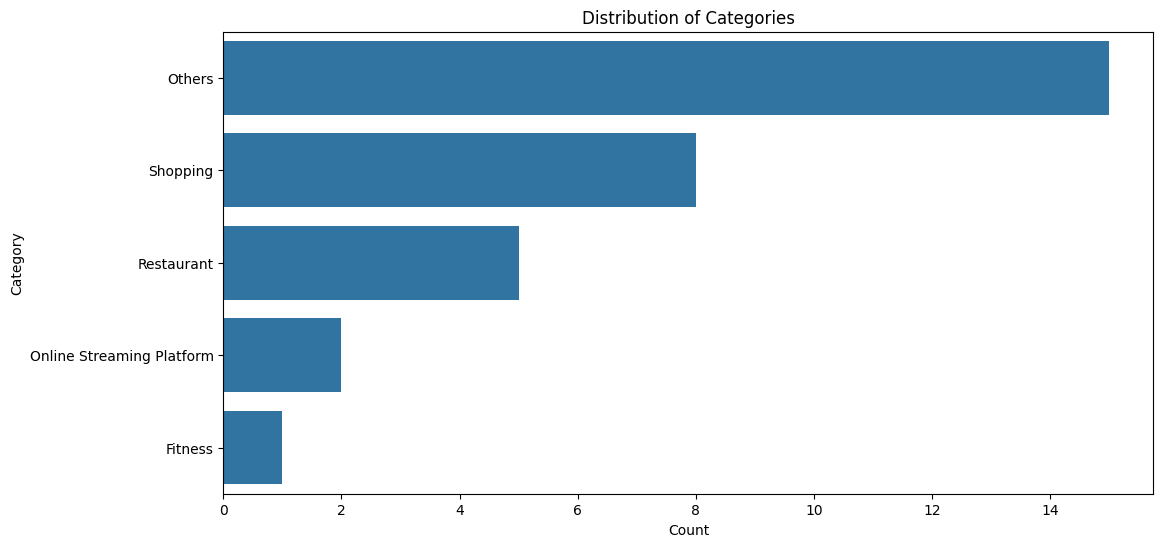

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(y='category', data=finance_df, order=finance_df['category'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Distribution of Categories')
plt.show()

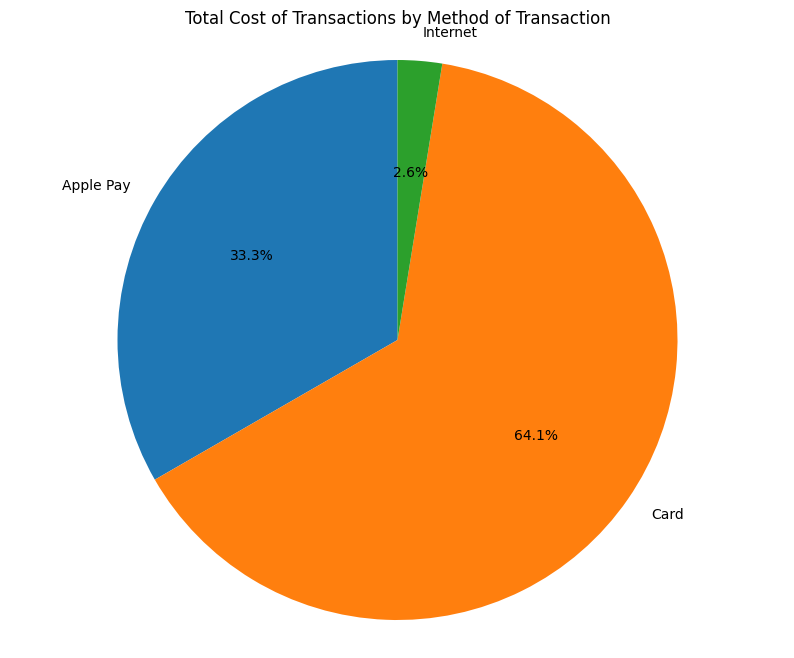

In [47]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
transaction_totals = finance_df.groupby('MethodOfTransaction')['amount'].sum()

plt.figure(figsize=(10, 8))
plt.pie(transaction_totals, labels=transaction_totals.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Total Cost of Transactions by Method of Transaction')
plt.show()


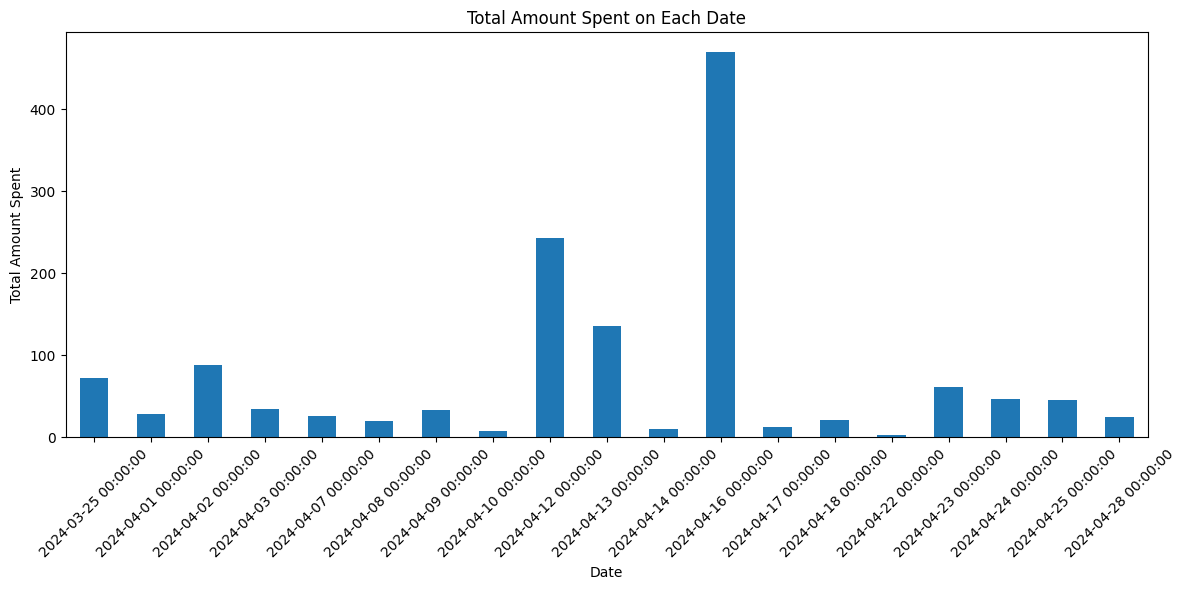

In [48]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
date_totals = finance_df.groupby('date')['amount'].sum()

plt.figure(figsize=(12, 6))
date_totals.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Total Amount Spent')
plt.title('Total Amount Spent on Each Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [49]:
top_spending_names = finance_df.groupby('name')['amount'].sum().nlargest(15)
print(top_spending_names)

name
USCIS I-                                  470.00
SAM'S CLUB                                240.25
PATEL BROTHERS                            107.06
USMANIA FINE DINING                        91.59
JEWEL                                      81.92
DISPUTE CRREVERSAL -HERTZ CAR RENTAL $     72.88
LAMEXICANA                                 47.05
TARGET                                     42.91
COMMONWEALTH COMPANY                       25.89
NETFLIX                                    25.06
COMCAST                                    25.00
PAYRANGE                                   25.00
CHATGPT SUBSCRIPTION                       21.80
SUBWAY                                     20.17
FARM SUPERMARKET                           19.68
Name: amount, dtype: float64


In [50]:
finance_df.dtypes

date                   datetime64[ns]
name                           object
amount                        float64
MethodOfTransaction            object
category                       object
dtype: object

In [51]:
top_spending_category = finance_df.groupby('category')['amount'].sum().nlargest(15)
print(top_spending_category)


category
Others                       838.64
Shopping                     368.07
Restaurant                   139.22
Online Streaming Platform     32.55
Fitness                       10.00
Name: amount, dtype: float64


# **Sending to S3 bucket**

In [52]:
pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 8.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import boto3

# Get user input for folder name
folder_name = pdf_name

# Assuming 'finance_df' is your DataFrame
filename = f"{folder_name}.csv"  # Combine folder and filename

# Configure AWS credentials (replace with your actual credentials)
s3 = boto3.client('s3',
                  aws_access_key_id='xxxxxxxxxx',
                  aws_secret_access_key='xxxxxxxxxxxxx')

# Convert DataFrame to CSV in-memory
csv_data = finance_df.to_csv(None, index=False)  # Don't write index to CSV

# Upload the CSV data to S3 bucket
s3.put_object(Body=csv_data.encode('utf-8'), Bucket='wealth-management--credit-statement', Key=filename)

print(f"CSV file uploaded to s3://wealth-management--credit-statement/{filename}")


CSV file uploaded to s3://wealth-management--credit-statement/04-28-2024.csv
